# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

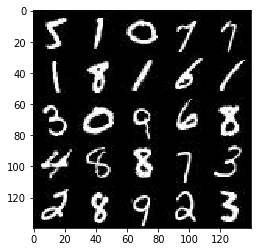

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

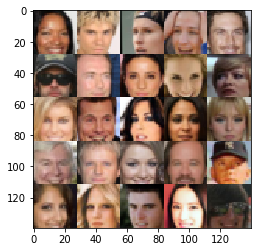

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='lr')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def myconv2d(x, size):
    return tf.layers.conv2d(x, size, 5, strides=2, padding='same',
                            kernel_initializer=tf.contrib.layers.xavier_initializer())

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    training = not reuse
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = myconv2d(images, 64)
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = myconv2d(relu1, 128)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = myconv2d(relu2, 256)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse=not is_train
    alpha=0.2
    quantum=7
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, quantum*quantum*512, kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, quantum, quantum, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())   
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    deps = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_dep = [dep for dep in deps if dep.name.startswith("discriminator")]
    g_dep = [dep for dep in deps if dep.name.startswith("generator")]
    
    with tf.control_dependencies(d_dep):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(g_dep):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    ## Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])            
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    print_every = 20
    show_every = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                ## Train Model
                steps += 1
                
                # batch images mapped to -1, 1
                batch_images = batch_images*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

            train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
            train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})
            print("Final of Epoch {}/{}...".format(epoch_i+1, epoch_count),
                  "Discriminator Loss: {:.4f}...".format(train_loss_d),
                  "Generator Loss: {:.4f}".format(train_loss_g))
            show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9407... Generator Loss: 0.7815
Epoch 1/2... Discriminator Loss: 1.5849... Generator Loss: 1.3883
Epoch 1/2... Discriminator Loss: 1.8182... Generator Loss: 0.7427
Epoch 1/2... Discriminator Loss: 1.6540... Generator Loss: 1.0887
Epoch 1/2... Discriminator Loss: 1.2882... Generator Loss: 0.9459


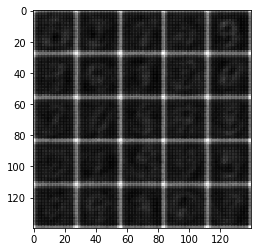

Epoch 1/2... Discriminator Loss: 1.5275... Generator Loss: 1.1074
Epoch 1/2... Discriminator Loss: 1.3313... Generator Loss: 1.0263
Epoch 1/2... Discriminator Loss: 1.3672... Generator Loss: 0.9782
Epoch 1/2... Discriminator Loss: 1.2699... Generator Loss: 1.2392
Epoch 1/2... Discriminator Loss: 1.0016... Generator Loss: 1.0966


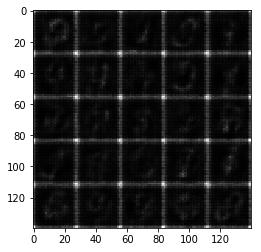

Epoch 1/2... Discriminator Loss: 1.1872... Generator Loss: 1.3098
Epoch 1/2... Discriminator Loss: 1.0932... Generator Loss: 1.1066
Epoch 1/2... Discriminator Loss: 1.3375... Generator Loss: 0.3921
Epoch 1/2... Discriminator Loss: 1.3521... Generator Loss: 0.4006
Epoch 1/2... Discriminator Loss: 1.5804... Generator Loss: 0.3099


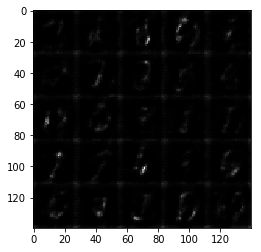

Epoch 1/2... Discriminator Loss: 1.6019... Generator Loss: 0.2873
Epoch 1/2... Discriminator Loss: 1.4851... Generator Loss: 0.3297
Epoch 1/2... Discriminator Loss: 1.6272... Generator Loss: 0.2796
Epoch 1/2... Discriminator Loss: 1.1780... Generator Loss: 1.0444
Epoch 1/2... Discriminator Loss: 1.2170... Generator Loss: 1.3039


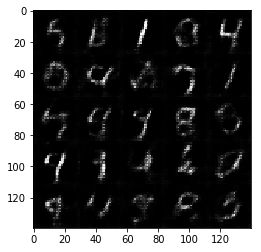

Epoch 1/2... Discriminator Loss: 0.9828... Generator Loss: 1.1387
Epoch 1/2... Discriminator Loss: 0.9772... Generator Loss: 1.5234
Epoch 1/2... Discriminator Loss: 1.3057... Generator Loss: 1.1215
Epoch 1/2... Discriminator Loss: 1.4123... Generator Loss: 0.3964
Epoch 1/2... Discriminator Loss: 1.2158... Generator Loss: 1.3004


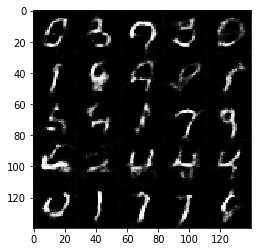

Epoch 1/2... Discriminator Loss: 1.5318... Generator Loss: 0.3161
Epoch 1/2... Discriminator Loss: 1.2793... Generator Loss: 1.2482
Epoch 1/2... Discriminator Loss: 1.2426... Generator Loss: 0.9967
Epoch 1/2... Discriminator Loss: 1.4170... Generator Loss: 0.3864
Epoch 1/2... Discriminator Loss: 1.1968... Generator Loss: 0.6381


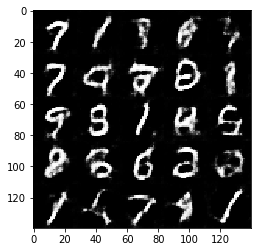

Epoch 1/2... Discriminator Loss: 1.1820... Generator Loss: 0.6063
Epoch 1/2... Discriminator Loss: 1.0653... Generator Loss: 1.1228
Epoch 1/2... Discriminator Loss: 1.1559... Generator Loss: 1.2331
Epoch 1/2... Discriminator Loss: 1.2052... Generator Loss: 0.6980
Epoch 1/2... Discriminator Loss: 1.4795... Generator Loss: 0.3350


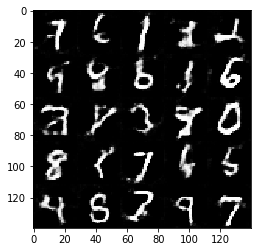

Epoch 1/2... Discriminator Loss: 1.4384... Generator Loss: 0.4000
Epoch 1/2... Discriminator Loss: 1.1421... Generator Loss: 0.8637
Epoch 1/2... Discriminator Loss: 1.3909... Generator Loss: 0.4062
Epoch 1/2... Discriminator Loss: 1.4337... Generator Loss: 0.3737
Epoch 1/2... Discriminator Loss: 1.6979... Generator Loss: 0.2516


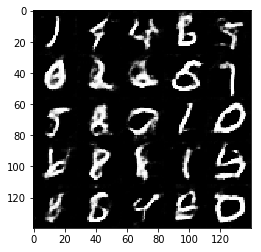

Epoch 1/2... Discriminator Loss: 1.2721... Generator Loss: 0.4500
Epoch 1/2... Discriminator Loss: 1.4839... Generator Loss: 1.6050
Epoch 1/2... Discriminator Loss: 1.0672... Generator Loss: 1.3783
Epoch 1/2... Discriminator Loss: 1.2217... Generator Loss: 1.1465
Epoch 1/2... Discriminator Loss: 1.0469... Generator Loss: 0.7366


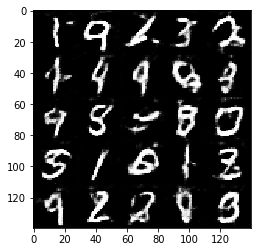

Epoch 1/2... Discriminator Loss: 1.5514... Generator Loss: 0.3015
Final of Epoch 1/2... Discriminator Loss: 0.9969... Generator Loss: 0.7928


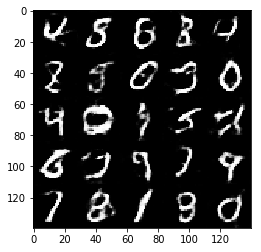

Epoch 2/2... Discriminator Loss: 1.6908... Generator Loss: 0.2607
Epoch 2/2... Discriminator Loss: 1.1198... Generator Loss: 0.6239
Epoch 2/2... Discriminator Loss: 1.2592... Generator Loss: 1.2631
Epoch 2/2... Discriminator Loss: 1.1449... Generator Loss: 0.6602
Epoch 2/2... Discriminator Loss: 1.2292... Generator Loss: 1.9391


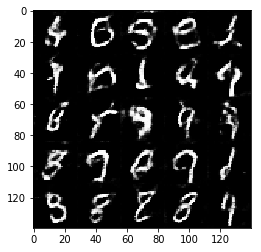

Epoch 2/2... Discriminator Loss: 0.8846... Generator Loss: 1.1275
Epoch 2/2... Discriminator Loss: 1.0438... Generator Loss: 1.2099
Epoch 2/2... Discriminator Loss: 1.3539... Generator Loss: 0.4208
Epoch 2/2... Discriminator Loss: 1.2122... Generator Loss: 0.4890
Epoch 2/2... Discriminator Loss: 1.1918... Generator Loss: 0.5153


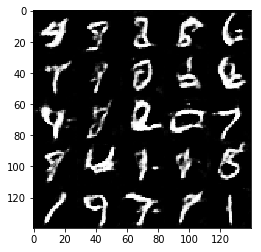

Epoch 2/2... Discriminator Loss: 1.0028... Generator Loss: 0.9400
Epoch 2/2... Discriminator Loss: 1.5576... Generator Loss: 0.3359
Epoch 2/2... Discriminator Loss: 0.9571... Generator Loss: 0.8787
Epoch 2/2... Discriminator Loss: 0.9977... Generator Loss: 0.6412
Epoch 2/2... Discriminator Loss: 1.1445... Generator Loss: 0.5436


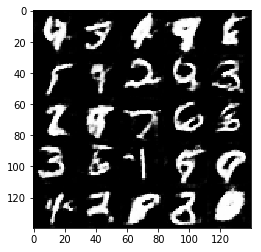

Epoch 2/2... Discriminator Loss: 0.9006... Generator Loss: 0.8797
Epoch 2/2... Discriminator Loss: 0.8946... Generator Loss: 0.6971
Epoch 2/2... Discriminator Loss: 1.5827... Generator Loss: 0.3062
Epoch 2/2... Discriminator Loss: 1.0694... Generator Loss: 0.6901
Epoch 2/2... Discriminator Loss: 1.0546... Generator Loss: 0.6494


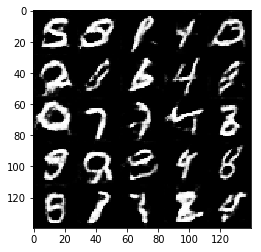

Epoch 2/2... Discriminator Loss: 1.0872... Generator Loss: 0.6104
Epoch 2/2... Discriminator Loss: 0.9016... Generator Loss: 0.8213
Epoch 2/2... Discriminator Loss: 1.5656... Generator Loss: 2.0167
Epoch 2/2... Discriminator Loss: 0.8807... Generator Loss: 0.8297
Epoch 2/2... Discriminator Loss: 1.0892... Generator Loss: 1.8513


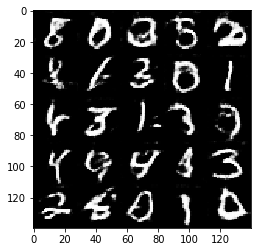

Epoch 2/2... Discriminator Loss: 1.0228... Generator Loss: 0.6741
Epoch 2/2... Discriminator Loss: 0.6882... Generator Loss: 1.1832
Epoch 2/2... Discriminator Loss: 1.3795... Generator Loss: 0.4290
Epoch 2/2... Discriminator Loss: 1.0218... Generator Loss: 0.6872
Epoch 2/2... Discriminator Loss: 0.6366... Generator Loss: 1.1418


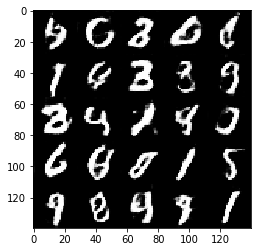

Epoch 2/2... Discriminator Loss: 1.2502... Generator Loss: 1.8567
Epoch 2/2... Discriminator Loss: 1.0871... Generator Loss: 0.6029
Epoch 2/2... Discriminator Loss: 1.5284... Generator Loss: 0.3780
Epoch 2/2... Discriminator Loss: 1.1629... Generator Loss: 0.5307
Epoch 2/2... Discriminator Loss: 0.7477... Generator Loss: 1.1270


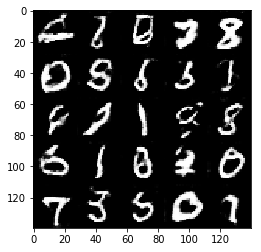

Epoch 2/2... Discriminator Loss: 0.9338... Generator Loss: 0.8018
Epoch 2/2... Discriminator Loss: 1.5362... Generator Loss: 0.3195
Epoch 2/2... Discriminator Loss: 0.9377... Generator Loss: 0.7910
Epoch 2/2... Discriminator Loss: 1.0730... Generator Loss: 0.5731
Epoch 2/2... Discriminator Loss: 1.9032... Generator Loss: 0.2199


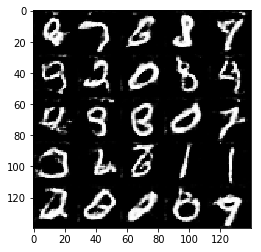

Epoch 2/2... Discriminator Loss: 0.9127... Generator Loss: 0.8081
Epoch 2/2... Discriminator Loss: 1.3750... Generator Loss: 0.4121
Epoch 2/2... Discriminator Loss: 2.4632... Generator Loss: 0.1223
Epoch 2/2... Discriminator Loss: 0.6715... Generator Loss: 1.2157
Epoch 2/2... Discriminator Loss: 0.7933... Generator Loss: 0.9030


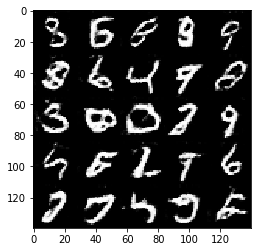

Epoch 2/2... Discriminator Loss: 1.2596... Generator Loss: 0.4482
Final of Epoch 2/2... Discriminator Loss: 0.9574... Generator Loss: 1.1712


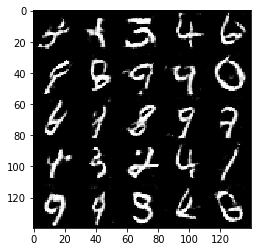

In [12]:
batch_size = 64
z_dim = 100
beta1 = 0.1
learning_rate = 0.0002

tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5239... Generator Loss: 2.5924
Epoch 1/1... Discriminator Loss: 1.5628... Generator Loss: 1.8555
Epoch 1/1... Discriminator Loss: 0.8496... Generator Loss: 3.1725
Epoch 1/1... Discriminator Loss: 0.8288... Generator Loss: 3.7708
Epoch 1/1... Discriminator Loss: 0.2756... Generator Loss: 2.1851


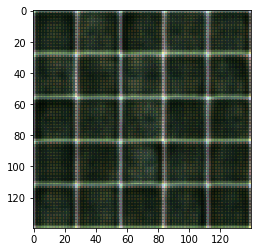

Epoch 1/1... Discriminator Loss: 1.0836... Generator Loss: 3.2109
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 3.7732
Epoch 1/1... Discriminator Loss: 0.4937... Generator Loss: 3.4662
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 3.3967
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 3.1435


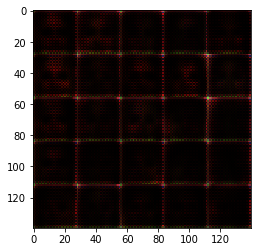

Epoch 1/1... Discriminator Loss: 1.0081... Generator Loss: 2.5448
Epoch 1/1... Discriminator Loss: 0.3566... Generator Loss: 3.6311
Epoch 1/1... Discriminator Loss: 0.5416... Generator Loss: 1.2867
Epoch 1/1... Discriminator Loss: 1.8351... Generator Loss: 0.2214
Epoch 1/1... Discriminator Loss: 1.6839... Generator Loss: 0.2888


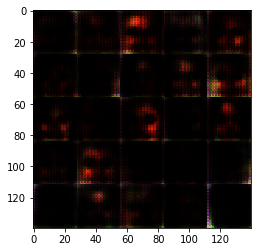

Epoch 1/1... Discriminator Loss: 0.4259... Generator Loss: 2.5360
Epoch 1/1... Discriminator Loss: 2.4018... Generator Loss: 2.0284
Epoch 1/1... Discriminator Loss: 1.0564... Generator Loss: 3.4123
Epoch 1/1... Discriminator Loss: 0.2063... Generator Loss: 3.7706
Epoch 1/1... Discriminator Loss: 1.6625... Generator Loss: 0.2666


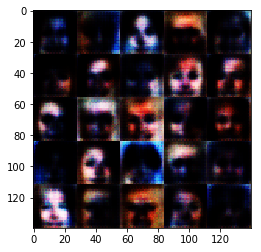

Epoch 1/1... Discriminator Loss: 1.6382... Generator Loss: 0.2746
Epoch 1/1... Discriminator Loss: 1.9162... Generator Loss: 1.2676
Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 1.2016
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 2.3783
Epoch 1/1... Discriminator Loss: 0.8725... Generator Loss: 1.4496


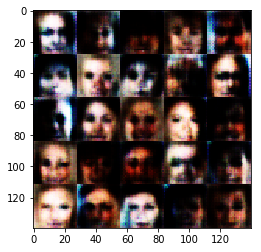

Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 3.0641
Epoch 1/1... Discriminator Loss: 0.6135... Generator Loss: 1.3662
Epoch 1/1... Discriminator Loss: 0.6837... Generator Loss: 1.3082
Epoch 1/1... Discriminator Loss: 0.8043... Generator Loss: 2.8039
Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 1.0260


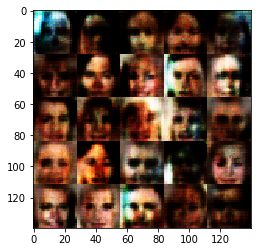

Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 1.6777
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 0.6975... Generator Loss: 0.9825
Epoch 1/1... Discriminator Loss: 0.6844... Generator Loss: 1.3010
Epoch 1/1... Discriminator Loss: 0.8882... Generator Loss: 0.8839


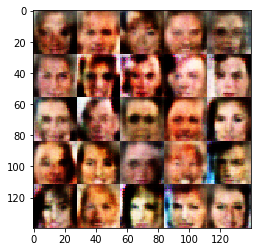

Epoch 1/1... Discriminator Loss: 0.7389... Generator Loss: 2.2305
Epoch 1/1... Discriminator Loss: 1.0522... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 0.5771
Epoch 1/1... Discriminator Loss: 1.7950... Generator Loss: 1.4611
Epoch 1/1... Discriminator Loss: 0.4932... Generator Loss: 2.6571


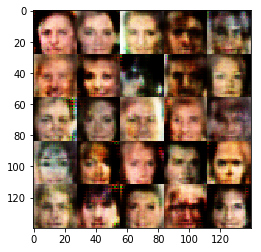

Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 0.5208
Epoch 1/1... Discriminator Loss: 1.5848... Generator Loss: 0.3013
Epoch 1/1... Discriminator Loss: 0.6994... Generator Loss: 1.9045
Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 0.7223... Generator Loss: 0.8820


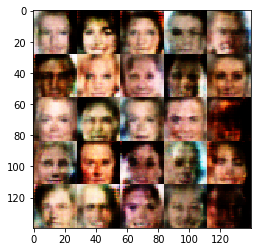

Epoch 1/1... Discriminator Loss: 0.6856... Generator Loss: 1.6761
Epoch 1/1... Discriminator Loss: 0.7552... Generator Loss: 0.9583
Epoch 1/1... Discriminator Loss: 0.7854... Generator Loss: 2.0591
Epoch 1/1... Discriminator Loss: 0.5499... Generator Loss: 1.7689
Epoch 1/1... Discriminator Loss: 0.4763... Generator Loss: 1.6632


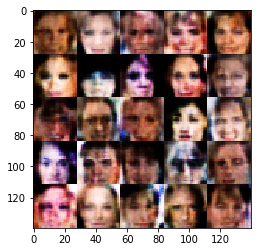

Epoch 1/1... Discriminator Loss: 0.8314... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.6253... Generator Loss: 0.3747
Epoch 1/1... Discriminator Loss: 0.8687... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 0.8214... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.3582


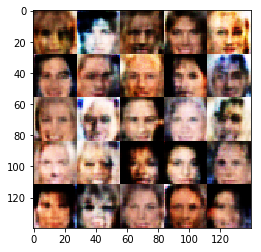

Epoch 1/1... Discriminator Loss: 0.3885... Generator Loss: 1.8673
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 2.0224
Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 2.1276
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 1.8660
Epoch 1/1... Discriminator Loss: 0.5200... Generator Loss: 2.3571


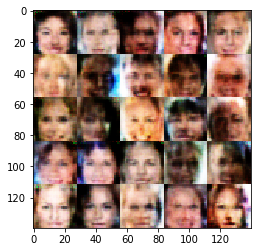

Epoch 1/1... Discriminator Loss: 0.6633... Generator Loss: 0.9681
Epoch 1/1... Discriminator Loss: 0.6443... Generator Loss: 1.0307
Epoch 1/1... Discriminator Loss: 0.6351... Generator Loss: 0.9374
Epoch 1/1... Discriminator Loss: 0.9227... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 2.2624... Generator Loss: 0.1289


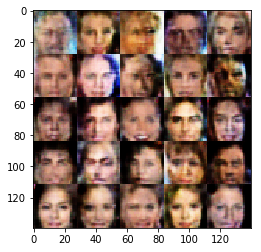

Epoch 1/1... Discriminator Loss: 0.4287... Generator Loss: 1.8315
Epoch 1/1... Discriminator Loss: 0.3046... Generator Loss: 2.0934
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.4469
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.4054
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 1.4341


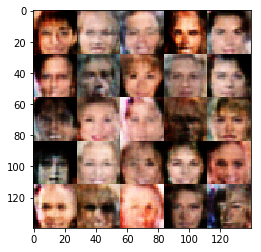

Epoch 1/1... Discriminator Loss: 0.3006... Generator Loss: 1.9241
Epoch 1/1... Discriminator Loss: 0.8564... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.3335
Epoch 1/1... Discriminator Loss: 0.6635... Generator Loss: 1.0132
Epoch 1/1... Discriminator Loss: 1.5457... Generator Loss: 0.8257


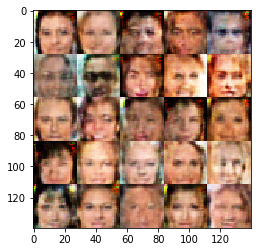

Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 2.1440
Epoch 1/1... Discriminator Loss: 2.2959... Generator Loss: 0.1218
Epoch 1/1... Discriminator Loss: 0.7587... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 0.8115... Generator Loss: 1.0343
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 0.6724


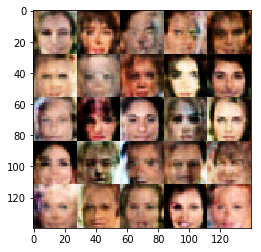

Epoch 1/1... Discriminator Loss: 0.3029... Generator Loss: 3.3472
Epoch 1/1... Discriminator Loss: 0.8823... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 0.8845... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 0.6055... Generator Loss: 1.2693
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 1.4924


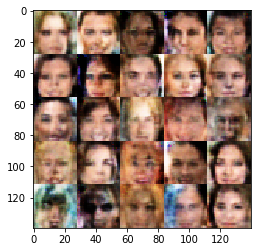

Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.5578
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 2.5346
Epoch 1/1... Discriminator Loss: 0.6486... Generator Loss: 2.6517
Epoch 1/1... Discriminator Loss: 0.7201... Generator Loss: 0.9356
Epoch 1/1... Discriminator Loss: 0.5198... Generator Loss: 1.2640


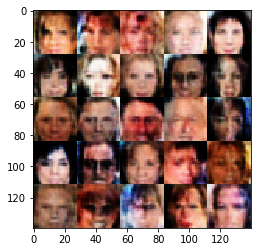

Epoch 1/1... Discriminator Loss: 0.9704... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.3747
Epoch 1/1... Discriminator Loss: 1.8300... Generator Loss: 0.2183
Epoch 1/1... Discriminator Loss: 0.4388... Generator Loss: 2.1272
Epoch 1/1... Discriminator Loss: 0.8456... Generator Loss: 0.7788


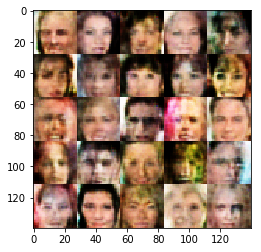

Epoch 1/1... Discriminator Loss: 0.8311... Generator Loss: 1.2617
Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 1.1331
Epoch 1/1... Discriminator Loss: 0.6465... Generator Loss: 2.0615
Epoch 1/1... Discriminator Loss: 0.4656... Generator Loss: 1.4900
Epoch 1/1... Discriminator Loss: 0.6047... Generator Loss: 2.6955


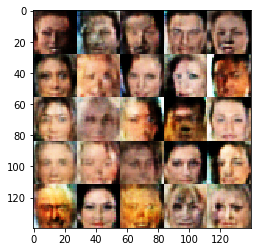

Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 0.5368... Generator Loss: 1.4482
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 1.3922
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 0.5969
Epoch 1/1... Discriminator Loss: 1.6240... Generator Loss: 0.3909


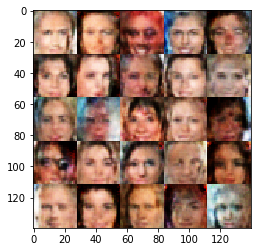

Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 0.4286
Epoch 1/1... Discriminator Loss: 0.7160... Generator Loss: 1.3582
Epoch 1/1... Discriminator Loss: 1.7507... Generator Loss: 2.0368
Epoch 1/1... Discriminator Loss: 0.8598... Generator Loss: 0.9516
Epoch 1/1... Discriminator Loss: 0.3487... Generator Loss: 1.9420


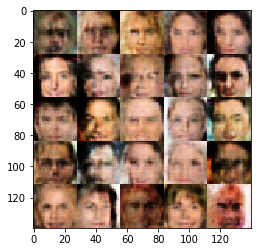

Epoch 1/1... Discriminator Loss: 0.5276... Generator Loss: 1.7037
Epoch 1/1... Discriminator Loss: 1.9534... Generator Loss: 2.4557
Epoch 1/1... Discriminator Loss: 1.0452... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 0.9196... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 0.5281... Generator Loss: 1.3760


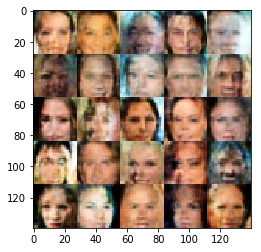

Epoch 1/1... Discriminator Loss: 0.7416... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 0.9722... Generator Loss: 1.9624
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.4165
Epoch 1/1... Discriminator Loss: 1.6393... Generator Loss: 2.1389
Epoch 1/1... Discriminator Loss: 1.5708... Generator Loss: 0.2808


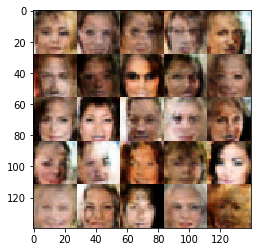

Epoch 1/1... Discriminator Loss: 0.6578... Generator Loss: 1.9868
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 0.5847
Epoch 1/1... Discriminator Loss: 0.6097... Generator Loss: 2.6645
Epoch 1/1... Discriminator Loss: 0.8521... Generator Loss: 2.4878
Epoch 1/1... Discriminator Loss: 0.3783... Generator Loss: 2.4481


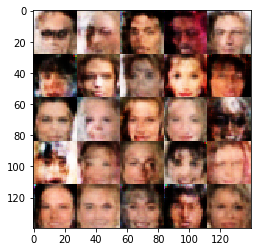

Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.5286
Epoch 1/1... Discriminator Loss: 0.7305... Generator Loss: 0.9730
Epoch 1/1... Discriminator Loss: 0.6651... Generator Loss: 1.3977
Epoch 1/1... Discriminator Loss: 1.6123... Generator Loss: 0.2998
Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 0.6529


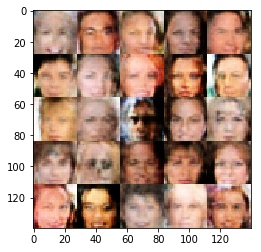

Epoch 1/1... Discriminator Loss: 0.5428... Generator Loss: 1.6906
Epoch 1/1... Discriminator Loss: 0.6978... Generator Loss: 0.8907
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.4340
Epoch 1/1... Discriminator Loss: 0.1582... Generator Loss: 3.3534
Epoch 1/1... Discriminator Loss: 0.6537... Generator Loss: 1.0605


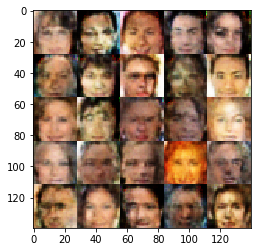

Epoch 1/1... Discriminator Loss: 0.8250... Generator Loss: 3.6940
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 0.9730
Epoch 1/1... Discriminator Loss: 0.9870... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 0.5815... Generator Loss: 3.4295
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 1.4107


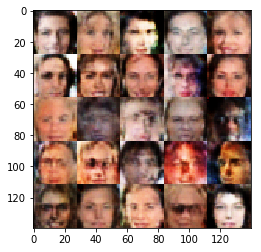

Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.5058
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.5738
Epoch 1/1... Discriminator Loss: 0.4590... Generator Loss: 2.7414
Epoch 1/1... Discriminator Loss: 0.7830... Generator Loss: 1.5804
Epoch 1/1... Discriminator Loss: 0.8197... Generator Loss: 0.7385


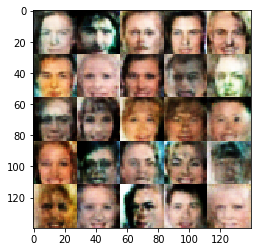

Epoch 1/1... Discriminator Loss: 0.5649... Generator Loss: 1.0836
Epoch 1/1... Discriminator Loss: 0.5559... Generator Loss: 1.7503
Epoch 1/1... Discriminator Loss: 0.2109... Generator Loss: 3.7075
Epoch 1/1... Discriminator Loss: 0.8204... Generator Loss: 1.3179
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 2.1844


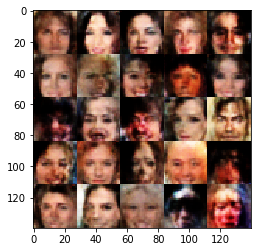

Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 2.2696
Epoch 1/1... Discriminator Loss: 0.5729... Generator Loss: 1.2800
Epoch 1/1... Discriminator Loss: 0.8910... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 0.8644... Generator Loss: 1.1915


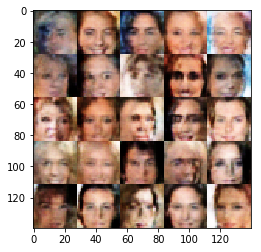

Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 0.8813
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 0.5954
Epoch 1/1... Discriminator Loss: 0.4886... Generator Loss: 1.4168
Final of Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.4234


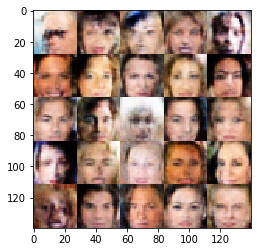

In [13]:
z_dim = 100
batch_size = 64
beta1 = 0.1
learning_rate = 0.0002

tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.